# Chapter 9
## Botzmann machines


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).
    
Learning goals:
1. Implement a Boltzmann machine

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import urllib2
import scipy.misc as sp

A (unrestricted) Boltzmann machine is like a Hopfield network with stochastic state updates. The degree of randomness allows for investiations both in Hopfield networks and in how real associative memory may work (biological neurons are stochastic, too; and there are ideas that they make use of the irreducible noise). 

### Exercise 1: Flip-flop  (2 points)

This is the **Boltzmann distribution** for a state $\mathbf{x}$:

$p(\mathbf{x}) = \frac{1}{Z} \exp( \frac{-E(\mathbf{x})}{T} ) $

with the state sum $Z$: 

$Z = \sum_{\mathbf{x}}  \exp(\frac{-E(\mathbf{x})}{T})$


Use it to derive the stable probability distribution of the **flip-flop** (2 units with bias $0.5$, connected with the identical weight $w_{12} = w_{21} = −1$). 

Assume the temperature $T=1$. Start by first computing $E(\mathbf{x})$ for each possible state of the Hopfield network.

### Solution 1
$ E(\textrm{x}) = -\frac{1}{2}\textrm{x}^T\textrm{W}\textrm{x} - \textrm{x}^T\textrm{b} \\
E(\textrm{x}) = - \frac{1}{2}\textrm{x}^T\left(\begin{array}{cc} 
0 & -1\\ 
-1 & 0
\end{array}\right)\textrm{x} - \textrm{x}^T\textrm{(0.5, 0.5)} \\ 
E(\textrm{[0,0]}) = 0\\
E(\textrm{[0,1]}) = -0.5\\
E(\textrm{[1,0]}) = -0.5\\
E(\textrm{[1,1]}) = 0 \\\\
Z = \sum_{\mathbf{x}}  \exp(-E(\mathbf{x})) \\
Z = \exp(0) + \exp(0.5) + \exp(0.5) + \exp(0)\\
Z = 1 + 1.65 + 1.65 + 1 = 5.30 \\\\
P = \left(\begin{array}{c} 
0.19 \\ 
0.31 \\
0.31\\
0.19
\end{array}\right)
\textrm{Is this stable tho?}
$ 

Now you will implement your own Boltzmann machine. As in the Hopfield network assignment, we will use an image and its mirrored version as the patterns the Boltzmann machine should learn. 

Note that we use the binary representation here, not the bipolar one. 

In [2]:
# The source image
f = urllib2.urlopen("https://homepages.cae.wisc.edu/~ece533/images/watch.png")

# Read the image
x1 = mpimg.imread(f)

# Make binary
x1 = np.mean(sp.imresize(x1,10),2)
x1[x1 < np.mean(x1.flatten())] = 0   # Black
x1[x1 >= np.mean(x1.flatten())] = 1  # White
x1.astype("int32")

# Make duplicate but mirrored second image
x2 = np.fliplr(x1)

# Flatten images and put them into one matrix
sz = x1.shape
X = np.stack((x1.flatten(), x2.flatten()), axis=1)

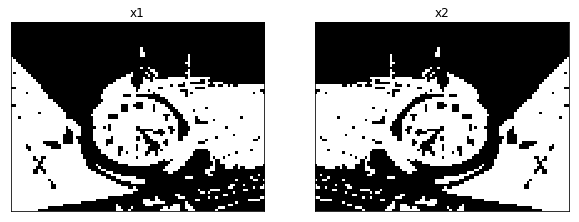

In [3]:
# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X[:, 0].reshape(sz), cmap="gray")
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_title("x1")

ax[1].imshow(X[:, 1].reshape(sz), cmap="gray")
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])
ax[1].set_title("x2")

### Exercise 2: The sigmoid (1 point)
Write a function `sigmoid(x)` that computes the *sigmoid activation function* $\sigma(x)=\frac{1}{1+exp(-x)}$.

### Solution 2

In [13]:
def sigmoid(x):
    Y = 1/(1+np.exp(-x))
    return Y

### Exercise 3: Probabilities (1 point)

Write a function `compute_probability(w, x, b, T)` that returns the probability that the state of node $x_i$ is set to $1$ ($0$ instead): 

$P(x_i=1)=\sigma(\frac{1}{T}(\mathbf{w}_i^{\top}\mathbf{x}+b_i))$

where $T$ is the temperature, $\mathbf{w}_i$ the weights and $b_i$ the bias of node $i$; and $\mathbf{x}$ the current state vector. $\sigma$ is the sigmoid activation function.

### Solution 3

In [32]:
def compute_probability(w, x, b, T):
    #print "w: {}, x: {}".format(w.shape, x.shape)
    Y = sigmoid((1/T)*(np.dot(w.T,x) + b)) #not sure if we need to index x, w and b ? What is x, w? Vector or matrix?
    #print Y
    return Y

### Exercise 4: Gibbs sampling  (2 points)
Write a function `gibbs_sampling(w, b, temperature=1.0, n_gibbs=20, n_burnin=10)` that approximates the model distribution for training a Boltzmann machine via Gibbs sampling. The Boltzmann machine is given by the current weights `w` and biases `b`.

1. Create an array `X` for saving the node states for each time step. Then initialize a random initial node state vector $\mathbf{x}^{(1)}$ and save it in `X[:,0]`. These are the node states for $t=1$.
1. For $t=2, ..., N$, where $N$ is the number of Gibbs sampling steps `n_gibbs`:
    1. Compute the probability $P(x^{t+1}_i = 1)$ for all node states $x^{t}_i$ in `X[:,t]` (the previous state vector). 
    1. Determine the new binary state $x^{t+1}_i$ by drawing a random number between 0 and 1 using `np.random.rand()`, and comparing it with $P(x^{t+1}_i = 1)$. That is, depending on the probability for $1$, it should be set to $1$ or $0$ at time `t+1`. Save the new state in `X[i,t+1]`. 
1. Return `X` without the burn-in phase, that is without the first `n_burnin` samples. 

### Solution 4

In [63]:
def gibbs_sampling(w, b, temperature=1.0, n_gibbs=20, n_burnin=10):
    n_nodes = w.shape[0]
    
    # Initialize states
    X = np.zeros((n_nodes, n_gibbs))
                 
    # Initialize first state vector
    X[:,0] = np.random.randint(2, size=n_nodes)             
    # Loop over Gibbs samples
    
    # We skip the first 2 iterations (add 2 to t every it.), so n_gibbs-2. 
    # Then we also want to index the last element, in the decision the index is for X[i,t+1], so the t+1 also makes us subtract 1 more.
    # Thus, range(n_gibbs-3).
    
    for t in range(n_gibbs-3):
        t = t+2
        # Loop over nodes
        for i in range(n_nodes):         
            # Compute probability for state 1
            p = compute_probability(w[i,:], X[:,t], b[i], temperature)  
            # Sample whether it should change to 1
            if (np.random.rand() <= p):
                X[i,t+1] = 1
            else:
                X[i,t+1] = 0
    # Discard burn-in
    X = X[:, n_burnin:]
    return X

### Exercise 5: Expectations  (1 point)
Write a function `compute_expectations(X)` that computes the expectation (~mean over patterns / samples) of the partial derivatives for the weights and bias terms, given as: 

$$\frac{\partial J(x)}{\partial w_{ij}}=-x_ix_j$$
$$\frac{\partial J(x)}{\partial b_i}=-x_i$$

When running training you will compute these under the empirical and the model distribution (given as input `X`, which contains multiple patterns / sampling steps respectively). Note that if you use the dot product to compute $\frac{\partial J(x)}{\partial w_{ij}}$ you need to divide by the number of patterns / samples `N` in `X`. Check for yourself (on paper, with a small example matrix `X` with 2 patterns) why this is so when you make use of the dot product to compute all $- x_i x_j$ at once. It will also help you arranging the dot product correctly. 

Hint: $I$ is the number of nodes. Then the partial derivative for the weight update `dw` should have the shape $(I, I)$. 
You also need to set the diagonal is set to the correct values for Boltzmann machines. You can complete this exercise in 3 lines of code.  

### Solution 5

In [53]:
# Compute expectations
def compute_expectations(X):
    I, N = X.shape
    dw = np.dot(-X, X.T)/N
    np.fill_diagonal(dw, 0)
    return dw, -X[:,N-1] # Ehm we just kinda guessed this but whyyyy does this sort of work?

### Exercise 6: Boltzmann training  (1 point)
Now, with the components you wrote above, you can fill in the missing part in `boltzmann_train`. What is missing is updating the weights `w` and biases `b` with the information gathered from the empirical and model distribution, and the learning rate `eta`. Add the two lines performing this step below. 

### Solution 6

In [8]:
def boltzmann_train(XE, temperature=1.0, eta=0.01, n_epochs=5, n_gibbs=20, n_burnin=10):
    n_nodes, n_examples = XE.shape

    # Initialize weights:
    w = np.zeros((n_nodes, n_nodes))
    
    # Initialize biases:
    b = np.zeros(n_nodes)
    
    # Compute expectations under the empirical distribution. As we compute this on 
    # the training patterns, we only need to do it once: 
    dE_dw, dE_db = compute_expectations(XE)     

    # Loop over epochs: 
    for i_epoch in range(n_epochs):
        print("Epoch {}/{}.".format(1 + i_epoch, n_epochs))
        
        # Gibbs sampling with the current model:
        XM = gibbs_sampling(w, b, temperature, n_gibbs, n_burnin)

        # Compute expectations under the model distribution: 
        dEM_dw, dEM_db = compute_expectations(XM)

        # Update weights and biases
        w += eta * (dE_dw - dEM_dw)
        b += eta * (dE_db - dEM_db)
    
    # Force symmetry
    w = (w + w.T) / 2
    
    print("Training done.")
    
    return w, b

### Exercise 7: Dreaming (1 point)

Write a function `boltzmann_dream(w, b, temperature=1.0, n_epochs=20)` that you can use to sample images from a previously trained Boltzmann machine (given as `w` and `b`) that is left running on its own for `n_epochs`. This boils down to performing Gibbs sampling starting with a random state vector. Use your previously implemented functions. 

### Solution 7

In [60]:
# Boltzmann dreaming
def boltzmann_dream(w, b, temperature=1.0, n_epochs=20):
    X = gibbs_sampling(w, b, temperature, n_gibbs = n_epochs)
    return X

### Exercise 8 (1 point)

**1.** Train your Boltzmann machine with `boltzmann_train` on the two images saved in `X` (the empirical distribution `XE`). Use $T=1$, 20 Gibbs sampling steps, a burn-in phase of 10, 3 training epochs, and a learning rate of $0.01$. Then let your trained Boltzmann machine dream for 20 epochs via `boltzmann_dream`. Plot the last 5 states as images. 

**2.** Now, change the temperature to $T=5$. Again, train the Boltzmann machine, let it run freely for 20 epochs and then plot the last 5 states it creates. 

### Solution 8

Epoch 1/3.
Epoch 2/3.
Epoch 3/3.
Training done.


[]

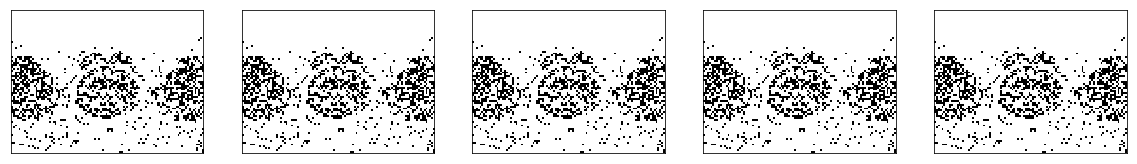

In [64]:
# Train Boltzmann machine
w, b = boltzmann_train(X, n_epochs = 3)
# Test Boltzmann machine
dreamX = boltzmann_dream(w, b)
# Plot last 5 samples
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(dreamX[:, 5].reshape(sz), cmap="gray")
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])

ax[1].imshow(dreamX[:, 6].reshape(sz), cmap="gray")
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])

ax[2].imshow(dreamX[:, 7].reshape(sz), cmap="gray")
ax[2].set_xticks([], [])
ax[2].set_yticks([], [])

ax[3].imshow(dreamX[:, 8].reshape(sz), cmap="gray")
ax[3].set_xticks([], [])
ax[3].set_yticks([], [])

ax[4].imshow(dreamX[:, 9].reshape(sz), cmap="gray")
ax[4].set_xticks([], [])
ax[4].set_yticks([], [])

# All plots are the same even though we use Gibbs sampling, so it should be random. 

Epoch 1/20.
Epoch 2/20.
Epoch 3/20.
Epoch 4/20.
Epoch 5/20.
Epoch 6/20.
Epoch 7/20.
Epoch 8/20.
Epoch 9/20.
Epoch 10/20.
Epoch 11/20.
Epoch 12/20.
Epoch 13/20.
Epoch 14/20.
Epoch 15/20.
Epoch 16/20.
Epoch 17/20.
Epoch 18/20.
Epoch 19/20.
Epoch 20/20.
Training done.


[]

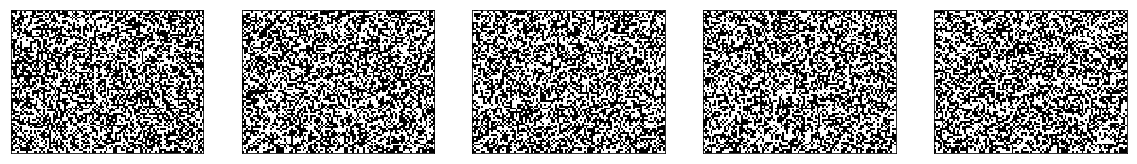

In [65]:
# Train Boltzmann machine
w, b = boltzmann_train(X, n_epochs = 20)
# Test Boltzmann machine
dreamX = boltzmann_dream(w, b, temperature = 5)
# Plot last 5 samples
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(dreamX[:, 5].reshape(sz), cmap="gray")
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])

ax[1].imshow(dreamX[:, 6].reshape(sz), cmap="gray")
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])

ax[2].imshow(dreamX[:, 7].reshape(sz), cmap="gray")
ax[2].set_xticks([], [])
ax[2].set_yticks([], [])

ax[3].imshow(dreamX[:, 8].reshape(sz), cmap="gray")
ax[3].set_xticks([], [])
ax[3].set_yticks([], [])

ax[4].imshow(dreamX[:, 9].reshape(sz), cmap="gray")
ax[4].set_xticks([], [])
ax[4].set_yticks([], [])

# All plots are the same even though we use Gibbs sampling, so it should be random. 